<a target="_blank" href="https://colab.research.google.com/github.com/giordamaug/HELP/blob/v2.0/notebooks/tuning.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
<a target="_blank" href="https://www.kaggle.com/notebooks/welcome?src=https://github.com/giordamaug/HELP/blob/v2.0/notebooks/tuning.ipynb">
  <img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open In Colab"/>
</a>

### 1. Load optuna library

In [4]:
import numpy as np
import pandas as pd
import os, sys 
import optuna

### 2. Download the input files
For a chosen tissue (here `Kidney`), download from Zenodo [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.12597679.svg)](https://doi.org/10.5281/zenodo.12597679)
 the label file (here `Kidney_HELP.csv`, computed as in Example 1) and the attribute files (here BIO `Kidney_BIO.csv`, CCcfs `Kidney_CCcfs.csv`, and N2V `Kidney_EmbN2V_128.csv`).  

Skip this step if you already have these input files locally.

In [3]:
from HELPpy.utility.utils import pdread_csv_fromurl
tissue='Kidney'
X_bio = pdread_csv_fromurl(f"https://zenodo.org/records/11917458/files/{tissue}_BIO.csv", index_col=0)
X_n2v = pdread_csv_fromurl(f"https://zenodo.org/records/11917458/files/{tissue}_EmbN2V_128.csv", index_col=0)
X_cccfs = pdread_csv_fromurl(f"https://zenodo.org/records/11917458/files/{tissue}_CCcfs.csv", index_col=0)
Y = pdread_csv_fromurl(f"https://zenodo.org/records/11917458/files/{tissue}_HELP.csv", index_col=0)

### 3. Pre-processing and merge input files
We apply pre-processing only to the BIO and CCcfs attributes.
+ constant attributes removal, and
+ data scaling with z-score.  

We also replace `E` label (positive label) and `aE` and `sNE` labels as 0 label (negative label), to address binary `E vs NE` classification.

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
df_y = Y.replace({'aE': 0, 'sNE': 0, 'E': 1})
print(df_y.value_counts(normalize=False))
consts = X_bio.columns[X_bio.nunique() <= 1].values
print(f"Removing {len(consts)} constant features ...")
X_bio = X_bio.drop(consts, axis=1)
X_bio = pd.DataFrame(StandardScaler().fit_transform(X_bio), index=X_bio.index, columns=X_bio.columns)
X_cccfs = pd.DataFrame(StandardScaler().fit_transform(X_cccfs), index=X_cccfs.index, columns=X_cccfs.columns)
consts = X_cccfs.columns[X_cccfs.nunique() <= 1].values
print(f"Removing {len(consts)} constant features ...")
X_cccfs = X_cccfs.drop(consts, axis=1)
df_X = pd.merge(X_bio, X_n2v, left_index=True, right_index=True, how='outer')
df_X = pd.merge(df_X, X_cccfs, left_index=True, right_index=True, how='outer')
idxs = np.intersect1d(df_y.index.values, df_X.index.values)
df_X = df_X.loc[idxs]
df_y = df_y.loc[idxs]
dataset = pd.concat([df_X,df_y], axis=1)

label
0        16678
1         1253
Name: count, dtype: int64
Removing 0 constant features ...
Removing 3 constant features ...


### 4. Compare models (Pycaret)

Start tuning session of models to be compared.

In [6]:
from pycaret.classification import *
clf = setup(data = dataset, 
             target = 'label',
             numeric_imputation = 'mean',
             categorical_features = [], session_id = 444,
             fold_strategy = "stratifiedkfold", fold=5,
             verbose = True)

,Description,Value
0,Session id,444
1,Target,label
2,Target type,Binary
3,Original data shape,"(17236, 3457)"
4,Transformed data shape,"(17236, 3457)"
5,Transformed train set shape,"(12065, 3457)"
6,Transformed test set shape,"(5171, 3457)"
7,Numeric features,3456
8,Rows with missing values,78.1%
9,Preprocess,True


Customize the metrics

In [8]:
from sklearn.metrics import *
from imblearn.metrics import specificity_score
try: 
    [remove_metric(m) for m in ['Precision', 'F1', 'Kappa', 'Recall']]  # remove unused metrics
    add_metric('Sensitivity', 'Sensitivity', recall_score, greater_is_better = True)
    add_metric('Specificity', 'Specificity', specificity_score, greater_is_better = True)
    add_metric('Balanced Accuracy', 'BA', balanced_accuracy_score, greater_is_better = True)
except: 
    pass
get_metrics()

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Multiclass,Custom
ID,,,,,,,,,
acc,Accuracy,Accuracy,<function accuracy_score at 0x17c128f70>,accuracy,pred,{},True,True,False
auc,AUC,AUC,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(roc_auc_score, response_method=('d...",pred_proba,"{'average': 'weighted', 'multi_class': 'ovr'}",True,True,False
mcc,MCC,MCC,<function matthews_corrcoef at 0x17c129510>,"make_scorer(matthews_corrcoef, response_method...",pred,{},True,True,False
Sensitivity,Sensitivity,Sensitivity,<pycaret.internal.metrics.EncodedDecodedLabels...,"make_scorer(recall_score, response_method='pre...",pred,{},True,True,True
Specificity,Specificity,Specificity,<pycaret.internal.metrics.EncodedDecodedLabels...,"make_scorer(specificity_score, response_method...",pred,{},True,True,True
Balanced Accuracy,BA,BA,<pycaret.internal.metrics.EncodedDecodedLabels...,"make_scorer(balanced_accuracy_score, response_...",pred,{},True,True,True


In [10]:
from icarlearn.ensemble.splitvotingens import *
savepath = "../pycaret"
tuned_models = []
tuners = []
hparams = {"n_voters" :[4, 6, 8, 10, 12, 14, 16, 18, 20]}
for clfname in [sveLGBM(),  sveXGB(), sveADA(), sveRF(), sveLDA()]:
    clf = create_model(clfname)
    tuned_model, tuner = tune_model(clf, optimize = 'BA', search_algorithm='grid', custom_grid=hparams, return_tuner=True)
    tuners += [tuner]
    save_model(tuned_model, os.path.join(savepath, f'saved_{clfname}_model'))
    
for clfname in ['lightgbm', 'xgboost', 'ada', 'rf', 'lda', 'lr', 'et', 'svm']:
    clf = create_model(clfname)
    tuned_model, tuner = tune_model(clf, optimize = 'BA', return_tuner=True)
    tuned_models += [tuned_model]
    tuners += [tuner]
    save_model(tuned_model, os.path.join(savepath, f'saved_{clfname}_model'))

results = compare_models(include=tuned_models, sort='BA')

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
               verbose=-1)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step

,Accuracy,AUC,MCC,Sensitivity,Specificity,BA
Fold,,,,,,
0,0.8815,0.9581,0.5267,0.8960,0.8804,0.8882
1,0.8707,0.9525,0.4976,0.8736,0.8705,0.8720
2,0.8595,0.9342,0.4731,0.8621,0.8593,0.8607
3,0.8748,0.9528,0.5183,0.9023,0.8727,0.8875
4,0.8711,0.9616,0.5195,0.9195,0.8674,0.8934
Mean,0.8715,0.9518,0.5070,0.8907,0.8700,0.8804
Std,0.0071,0.0095,0.0195,0.0205,0.0069,0.0122


,Accuracy,AUC,MCC,Sensitivity,Specificity,BA
Fold,,,,,,
0,0.8599,0.9576,0.4967,0.9133,0.8558,0.8845
1,0.8537,0.9519,0.4879,0.9138,0.8490,0.8814
2,0.8313,0.9341,0.4363,0.8736,0.8280,0.8508
3,0.8550,0.9520,0.4952,0.9253,0.8495,0.8874
4,0.8504,0.9606,0.4987,0.9483,0.8428,0.8955
Mean,0.8501,0.9512,0.4830,0.9148,0.8450,0.8799
Std,0.0099,0.0092,0.0236,0.0242,0.0094,0.0153


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Transformation Pipeline and Model Successfully Saved


,Accuracy,AUC,MCC,Sensitivity,Specificity,BA
Fold,,,,,,
0,0.8802,0.9589,0.5296,0.9075,0.8781,0.8928
1,0.8649,0.9494,0.4955,0.8908,0.8629,0.8768
2,0.8516,0.9345,0.4578,0.8563,0.8513,0.8538
3,0.8736,0.9519,0.5107,0.8908,0.8723,0.8815
4,0.8715,0.9621,0.5255,0.9310,0.8669,0.8990
Mean,0.8684,0.9514,0.5038,0.8953,0.8663,0.8808
Std,0.0097,0.0096,0.0260,0.0244,0.0091,0.0156


,Accuracy,AUC,MCC,Sensitivity,Specificity,BA
Fold,,,,,,
0,0.9010,0.9602,0.5620,0.8844,0.9022,0.8933
1,0.8914,0.9493,0.5348,0.8678,0.8933,0.8805
2,0.8806,0.9359,0.4972,0.8333,0.8843,0.8588
3,0.8943,0.9537,0.5462,0.8793,0.8955,0.8874
4,0.8947,0.9629,0.5522,0.8908,0.8950,0.8929
Mean,0.8924,0.9524,0.5385,0.8711,0.8941,0.8826
Std,0.0067,0.0095,0.0224,0.0203,0.0057,0.0128


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Transformation Pipeline and Model Successfully Saved


,Accuracy,AUC,MCC,Sensitivity,Specificity,BA
Fold,,,,,,
0,0.8786,0.9525,0.5318,0.9191,0.8754,0.8973
1,0.8632,0.9420,0.4927,0.8908,0.8611,0.8760
2,0.8537,0.9311,0.4583,0.8506,0.8540,0.8523
3,0.8670,0.9478,0.5017,0.8966,0.8647,0.8806
4,0.8628,0.9554,0.5079,0.9253,0.8580,0.8916
Mean,0.8651,0.9458,0.4985,0.8965,0.8626,0.8795
Std,0.0080,0.0086,0.0239,0.0264,0.0073,0.0156


,Accuracy,AUC,MCC,Sensitivity,Specificity,BA
Fold,,,,,,
0,0.8645,0.9500,0.5095,0.9249,0.8598,0.8923
1,0.8595,0.9440,0.4892,0.8966,0.8566,0.8766
2,0.8388,0.9306,0.4440,0.8678,0.8365,0.8522
3,0.8661,0.9472,0.4950,0.8851,0.8647,0.8749
4,0.8558,0.9555,0.4992,0.9310,0.8499,0.8905
Mean,0.8569,0.9454,0.4874,0.9011,0.8535,0.8773
Std,0.0098,0.0083,0.0227,0.0239,0.0097,0.0144


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Transformation Pipeline and Model Successfully Saved


,Accuracy,AUC,MCC,Sensitivity,Specificity,BA
Fold,,,,,,
0,0.8608,0.9412,0.4819,0.8786,0.8594,0.8690
1,0.8541,0.9356,0.4698,0.8736,0.8526,0.8631
2,0.8346,0.9184,0.4245,0.8391,0.8343,0.8367
3,0.8595,0.9379,0.4731,0.8621,0.8593,0.8607
4,0.8521,0.9524,0.4800,0.9023,0.8481,0.8752
Mean,0.8522,0.9371,0.4659,0.8711,0.8507,0.8609
Std,0.0094,0.0110,0.0211,0.0207,0.0093,0.0131


,Accuracy,AUC,MCC,Sensitivity,Specificity,BA
Fold,,,,,,
0,0.8927,0.9427,0.5255,0.8439,0.8964,0.8702
1,0.8798,0.9357,0.4956,0.8333,0.8834,0.8584
2,0.8661,0.9198,0.4487,0.7874,0.8723,0.8298
3,0.8906,0.9399,0.5225,0.8448,0.8941,0.8695
4,0.8831,0.9535,0.5154,0.8621,0.8848,0.8734
Mean,0.8825,0.9383,0.5016,0.8343,0.8862,0.8603
Std,0.0094,0.0110,0.0284,0.0252,0.0086,0.0160


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Transformation Pipeline and Model Successfully Saved


,Accuracy,AUC,MCC,Sensitivity,Specificity,BA
Fold,,,,,,
0,0.7410,0.8442,0.3031,0.8035,0.7362,0.7698
1,0.7302,0.8374,0.3004,0.8161,0.7235,0.7698
2,0.7041,0.8313,0.2790,0.8161,0.6954,0.7557
3,0.7484,0.8553,0.3083,0.7989,0.7445,0.7717
4,0.7348,0.8728,0.3289,0.8678,0.7244,0.7961
Mean,0.7317,0.8482,0.3039,0.8205,0.7248,0.7726
Std,0.0151,0.0147,0.0160,0.0246,0.0166,0.0131


,Accuracy,AUC,MCC,Sensitivity,Specificity,BA
Fold,,,,,,
0,0.7551,0.8720,0.3407,0.8555,0.7473,0.8014
1,0.7082,0.8446,0.2905,0.8333,0.6985,0.7659
2,0.7547,0.8291,0.3058,0.7816,0.7526,0.7671
3,0.7240,0.8539,0.3115,0.8506,0.7142,0.7824
4,0.7621,0.8808,0.3541,0.8678,0.7539,0.8109
Mean,0.7408,0.8561,0.3205,0.8378,0.7333,0.7855
Std,0.0209,0.0186,0.0234,0.0302,0.0227,0.0180


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Transformation Pipeline and Model Successfully Saved


,Accuracy,AUC,MCC,Sensitivity,Specificity,BA
Fold,,,,,,
0,0.9503,0.9595,0.5550,0.4277,0.9906,0.7092
1,0.9523,0.9523,0.5874,0.4828,0.9888,0.7358
2,0.9540,0.9382,0.6028,0.4943,0.9897,0.7420
3,0.9486,0.9570,0.5483,0.4425,0.9879,0.7152
4,0.9507,0.9587,0.5658,0.4483,0.9897,0.7190
Mean,0.9512,0.9531,0.5718,0.4591,0.9894,0.7242
Std,0.0018,0.0079,0.0204,0.0252,0.0009,0.0125


,Accuracy,AUC,MCC,Sensitivity,Specificity,BA
Fold,,,,,,
0,0.9474,0.9517,0.5438,0.4624,0.9848,0.7236
1,0.9465,0.9361,0.5473,0.4828,0.9826,0.7327
2,0.9441,0.9287,0.5254,0.4655,0.9812,0.7234
3,0.9515,0.9398,0.5797,0.4770,0.9884,0.7327
4,0.9503,0.9467,0.5722,0.4828,0.9866,0.7347
Mean,0.9479,0.9406,0.5537,0.4741,0.9847,0.7294
Std,0.0027,0.0080,0.0198,0.0086,0.0026,0.0049


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM

,Accuracy,AUC,MCC,Sensitivity,Specificity,BA
Fold,,,,,,
0,0.9499,0.9527,0.5445,0.3988,0.9924,0.6956
1,0.9519,0.9500,0.5828,0.4770,0.9888,0.7329
2,0.9536,0.9344,0.5969,0.4828,0.9902,0.7365
3,0.9494,0.9524,0.5595,0.4598,0.9875,0.7236
4,0.9515,0.9549,0.5766,0.4655,0.9893,0.7274
Mean,0.9513,0.9489,0.5721,0.4568,0.9896,0.7232
Std,0.0015,0.0074,0.0183,0.0301,0.0016,0.0145


,Accuracy,AUC,MCC,Sensitivity,Specificity,BA
Fold,,,,,,
0,0.8044,0.9461,0.4388,0.9538,0.7929,0.8733
1,0.7920,0.9331,0.4014,0.9023,0.7834,0.8428
2,0.7799,0.9229,0.3884,0.9023,0.7704,0.8364
3,0.8069,0.9343,0.4320,0.9310,0.7972,0.8641
4,0.7783,0.9376,0.4109,0.9540,0.7646,0.8593
Mean,0.7923,0.9348,0.4143,0.9287,0.7817,0.8552
Std,0.0119,0.0075,0.0188,0.0231,0.0125,0.0137


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Transformation Pipeline and Model Successfully Saved


,Accuracy,AUC,MCC,Sensitivity,Specificity,BA
Fold,,,,,,
0,0.9478,0.9389,0.5525,0.4798,0.9839,0.7318
1,0.9428,0.9279,0.5385,0.5172,0.9759,0.7466
2,0.9461,0.9170,0.5488,0.4943,0.9812,0.7377
3,0.9416,0.9222,0.5271,0.5057,0.9754,0.7406
4,0.9403,0.9387,0.5036,0.4655,0.9772,0.7214
Mean,0.9437,0.9289,0.5341,0.4925,0.9787,0.7356
Std,0.0028,0.0088,0.0176,0.0183,0.0033,0.0086


,Accuracy,AUC,MCC,Sensitivity,Specificity,BA
Fold,,,,,,
0,0.9449,0.9507,0.4869,0.3468,0.9911,0.6689
1,0.9494,0.9386,0.5682,0.4885,0.9853,0.7369
2,0.9461,0.9184,0.5081,0.3736,0.9906,0.6821
3,0.9461,0.9452,0.5152,0.3966,0.9888,0.6927
4,0.9424,0.9455,0.4791,0.3736,0.9866,0.6801
Mean,0.9458,0.9396,0.5115,0.3958,0.9885,0.6921
Std,0.0023,0.0113,0.0313,0.0490,0.0023,0.0236


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Transformation Pipeline and Model Successfully Saved


,Accuracy,AUC,MCC,Sensitivity,Specificity,BA
Fold,,,,,,
0,0.9407,0.9456,0.4219,0.2659,0.9929,0.6294
1,0.9441,0.9324,0.4763,0.3276,0.9920,0.6598
2,0.9499,0.9244,0.5400,0.3621,0.9955,0.6788
3,0.9470,0.9376,0.5067,0.3391,0.9942,0.6666
4,0.9461,0.9522,0.4987,0.3391,0.9933,0.6662
Mean,0.9455,0.9384,0.4887,0.3267,0.9936,0.6602
Std,0.0030,0.0097,0.0392,0.0324,0.0012,0.0166


,Accuracy,AUC,MCC,Sensitivity,Specificity,BA
Fold,,,,,,
0,0.8272,0.9089,0.4102,0.8324,0.8268,0.8296
1,0.8235,0.9041,0.4011,0.8218,0.8236,0.8227
2,0.7866,0.8864,0.3572,0.8218,0.7838,0.8028
3,0.8048,0.9073,0.3861,0.8391,0.8021,0.8206
4,0.8090,0.9114,0.3911,0.8391,0.8066,0.8228
Mean,0.8102,0.9036,0.3892,0.8308,0.8086,0.8197
Std,0.0145,0.0089,0.0180,0.0077,0.0156,0.0090


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Transformation Pipeline and Model Successfully Saved


,Accuracy,AUC,MCC,Sensitivity,Specificity,BA
Fold,,,,,,
0,0.9383,0.8421,0.4685,0.4162,0.9786,0.6974
1,0.9403,0.8321,0.4987,0.4540,0.9781,0.7161
2,0.9030,0.8481,0.4108,0.5575,0.9299,0.7437
3,0.9420,0.8487,0.4898,0.4080,0.9835,0.6958
4,0.9354,0.8697,0.4475,0.4023,0.9768,0.6895
Mean,0.9318,0.8481,0.4631,0.4476,0.9694,0.7085
Std,0.0145,0.0123,0.0316,0.0578,0.0199,0.0197


,Accuracy,AUC,MCC,Sensitivity,Specificity,BA
Fold,,,,,,
0,0.9453,0.9348,0.5868,0.6127,0.9710,0.7918
1,0.9403,0.9288,0.5658,0.6149,0.9656,0.7903
2,0.9449,0.9112,0.5761,0.5862,0.9728,0.7795
3,0.9515,0.9337,0.6329,0.6494,0.9750,0.8122
4,0.9457,0.9508,0.5975,0.6322,0.9701,0.8011
Mean,0.9455,0.9318,0.5918,0.6191,0.9709,0.7950
Std,0.0036,0.0127,0.0231,0.0211,0.0031,0.0110


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Transformation Pipeline and Model Successfully Saved


,Accuracy,AUC,MCC,Sensitivity,Specificity,BA
Fold,,,,,,
0,0.9188,0.8555,0.4746,0.5954,0.9438,0.7696
1,0.9258,0.8526,0.4979,0.5920,0.9518,0.7719
2,0.9130,0.8542,0.4053,0.4943,0.9455,0.7199
3,0.9184,0.8439,0.4498,0.5460,0.9473,0.7466
4,0.9105,0.8450,0.4314,0.5575,0.9379,0.7477
Mean,0.9173,0.8502,0.4518,0.5570,0.9452,0.7511
Std,0.0053,0.0048,0.0323,0.0368,0.0045,0.0189


,Accuracy,AUC,MCC,Sensitivity,Specificity,BA
Fold,,,,,,
0,0.9039,0.8524,0.4777,0.6879,0.9205,0.8042
1,0.9030,0.8443,0.4464,0.6264,0.9245,0.7755
2,0.8993,0.8464,0.4163,0.5862,0.9236,0.7549
3,0.9034,0.8374,0.4474,0.6264,0.9250,0.7757
4,0.8873,0.8317,0.4005,0.6092,0.9089,0.7590
Mean,0.8994,0.8424,0.4377,0.6272,0.9205,0.7739
Std,0.0063,0.0072,0.0269,0.0337,0.0060,0.0173


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Transformation Pipeline and Model Successfully Saved


,Accuracy,AUC,MCC,Sensitivity,Specificity,BA
Fold,,,,,,
0,0.9416,0.9462,0.4340,0.2775,0.9929,0.6352
1,0.9424,0.9313,0.4539,0.3046,0.9920,0.6483
2,0.9511,0.9204,0.5560,0.3851,0.9951,0.6901
3,0.9482,0.9407,0.5203,0.3448,0.9951,0.6700
4,0.9453,0.9493,0.4864,0.3218,0.9937,0.6578
Mean,0.9457,0.9376,0.4901,0.3268,0.9937,0.6603
Std,0.0036,0.0105,0.0441,0.0365,0.0012,0.0188


,Accuracy,AUC,MCC,Sensitivity,Specificity,BA
Fold,,,,,,
0,0.8388,0.8762,0.4040,0.7861,0.8429,0.8145
1,0.8247,0.8619,0.3635,0.7414,0.8312,0.7863
2,0.7969,0.8625,0.3409,0.7644,0.7995,0.7819
3,0.8442,0.8818,0.4022,0.7644,0.8504,0.8074
4,0.8259,0.8731,0.3709,0.7529,0.8316,0.7922
Mean,0.8261,0.8711,0.3763,0.7618,0.8311,0.7965
Std,0.0164,0.0078,0.0240,0.0148,0.0174,0.0125


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Transformation Pipeline and Model Successfully Saved


,Accuracy,AUC,MCC,Sensitivity,Specificity,BA
Fold,,,,,,
0,0.9399,0.9202,0.4858,0.4335,0.9790,0.7063
1,0.9412,0.9014,0.5035,0.4540,0.9790,0.7165
2,0.9407,0.8865,0.4914,0.4310,0.9803,0.7057
3,0.9424,0.9110,0.5132,0.4598,0.9799,0.7198
4,0.9399,0.9248,0.4964,0.4540,0.9777,0.7158
Mean,0.9408,0.9088,0.4981,0.4465,0.9792,0.7128
Std,0.0009,0.0137,0.0095,0.0118,0.0009,0.0058


,Accuracy,AUC,MCC,Sensitivity,Specificity,BA
Fold,,,,,,
0,0.8802,0.8411,0.3896,0.6185,0.9004,0.7595
1,0.8923,0.8209,0.4115,0.6092,0.9142,0.7617
2,0.8811,0.8347,0.3568,0.5517,0.9067,0.7292
3,0.8885,0.8318,0.4002,0.6034,0.9107,0.7571
4,0.8840,0.8111,0.3994,0.6207,0.9044,0.7626
Mean,0.8852,0.8279,0.3915,0.6007,0.9073,0.7540
Std,0.0046,0.0106,0.0187,0.0253,0.0048,0.0126


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Transformation Pipeline and Model Successfully Saved


,Model,Accuracy,AUC,MCC,Sensitivity,Specificity,BA,TT (Sec)
1,Extreme Gradient Boosting,0.7923,0.9348,0.4143,0.9287,0.7817,0.8552,3.1040
3,Random Forest Classifier,0.8102,0.9036,0.3892,0.8308,0.8086,0.8197,0.9120
6,Extra Trees Classifier,0.8261,0.8711,0.3763,0.7618,0.8311,0.7965,0.8620
4,Linear Discriminant Analysis,0.9455,0.9318,0.5918,0.6191,0.9709,0.7950,6.5100
5,Logistic Regression,0.8994,0.8424,0.4377,0.6272,0.9205,0.7739,1.5000
7,SVM - Linear Kernel,0.8852,0.8279,0.3915,0.6007,0.9073,0.7540,18.4220
2,Ada Boost Classifier,0.9437,0.9289,0.5341,0.4925,0.9787,0.7356,4.8420
0,Light Gradient Boosting Machine,0.9479,0.9406,0.5537,0.4741,0.9847,0.7294,2.0900


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will b

In [21]:
models = []
for clfname in ['sveLGBM',  'sveADA', 'sveRF', 'sveLDA', 
                'lightgbm', 'ada', 'rf', 'lda', 'lr', 'et', 'svm']:
    models += [load_model(os.path.join(savepath, f'saved_{clfname}_model'))]    
results = compare_models(include=models, sort='BA')

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


,Model,Accuracy,AUC,MCC,Sensitivity,Specificity,BA,TT (Sec)
0,sveLGBM,0.8501,0.9512,0.4830,0.9148,0.8450,0.8799,12.7980
1,sveADA,0.8569,0.9454,0.4874,0.9011,0.8535,0.8773,11.9080
2,sveRF,0.8839,0.9385,0.5048,0.8355,0.8876,0.8615,3.0280
6,Random Forest Classifier,0.8102,0.9036,0.3892,0.8308,0.8086,0.8197,0.9680
9,Extra Trees Classifier,0.8261,0.8711,0.3763,0.7618,0.8311,0.7965,0.7780
7,Linear Discriminant Analysis,0.9455,0.9318,0.5918,0.6191,0.9709,0.7950,6.5660
3,sveLDA,0.7408,0.8561,0.3205,0.8378,0.7333,0.7855,5.2000
8,Logistic Regression,0.8994,0.8424,0.4377,0.6272,0.9205,0.7739,1.5040
10,SVM - Linear Kernel,0.8852,0.8279,0.3915,0.6007,0.9073,0.7540,18.9600
5,Ada Boost Classifier,0.9437,0.9289,0.5341,0.4925,0.9787,0.7356,4.8080


In [24]:
df = pull()
df.to_csv("pycaret_best_tuned_classifier_metrics.csv", index=True)
print(df.to_latex())

\begin{tabular}{llrrrrrrr}
\toprule
 & Model & Accuracy & AUC & MCC & Sensitivity & Specificity & BA & TT (Sec) \\
\midrule
0 & sveLGBM & 0.850100 & 0.951200 & 0.483000 & 0.914800 & 0.845000 & 0.879900 & 12.798000 \\
1 & sveADA & 0.856900 & 0.945400 & 0.487400 & 0.901100 & 0.853500 & 0.877300 & 11.908000 \\
2 & sveRF & 0.883900 & 0.938500 & 0.504800 & 0.835500 & 0.887600 & 0.861500 & 3.028000 \\
6 & Random Forest Classifier & 0.810200 & 0.903600 & 0.389200 & 0.830800 & 0.808600 & 0.819700 & 0.968000 \\
9 & Extra Trees Classifier & 0.826100 & 0.871100 & 0.376300 & 0.761800 & 0.831100 & 0.796500 & 0.778000 \\
7 & Linear Discriminant Analysis & 0.945500 & 0.931800 & 0.591800 & 0.619100 & 0.970900 & 0.795000 & 6.566000 \\
3 & sveLDA & 0.740800 & 0.856100 & 0.320500 & 0.837800 & 0.733300 & 0.785500 & 5.200000 \\
8 & Logistic Regression & 0.899400 & 0.842400 & 0.437700 & 0.627200 & 0.920500 & 0.773900 & 1.504000 \\
10 & SVM - Linear Kernel & 0.885200 & 0.827900 & 0.391500 & 0.600700 & 0.9073

### 4. Tune model (Optuna)
Start tuning session

In [8]:
from __future__ import annotations
from icarlearn.ensemble.splitvotingens import SplitVotingEnsembleLGBM
from sklearn.metrics import *
from optuna import Trial
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective_cv(trial : Trial, X : pd.DataFrame, y : np.ndarray | pd.Series, random_state : int=42):
    params = {
        'learning_rate': trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        'n_voters': trial.suggest_int('n_voters', 1, 20, step=1),
        'n_estimators': trial.suggest_int('n_estimators', 60, 200, step=20),
        'boosting_type': trial.suggest_categorical("boosting_type", ["gbdt", "dart"])
    }
    gbm = SplitVotingEnsembleLGBM(**params)
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    ba_scorer = make_scorer(balanced_accuracy_score)
    scores = cross_val_score(gbm, X, y, scoring=ba_scorer, cv=kf)
    return np.mean(scores)

savepath = '../results'
study = optuna.create_study(
    study_name=f'velgbm_{tissue}',
    direction='maximize',
    load_if_exists=True,
    #storage=f'sqlite:///{savepath}/veLGBM_{tissue}_ba_cv.db'
    )
study.optimize(lambda trial: objective_cv(trial, df_X, df_y), n_trials=50)
best_params = study.best_params
print('Best Params:', best_params)
df = study.trials_dataframe()
#df.to_csv(os.path.join(f'velgbm_{tissue}_hypersearch_ba_cv_2.csv'))
df.sort_values('value', ascending=False)

[I 2024-07-01 14:40:28,367] A new study created in memory with name: velgbm_Kidney
[I 2024-07-01 14:42:22,318] Trial 0 finished with value: 0.848340285785798 and parameters: {'learning_rate': 0.015277731369572148, 'n_voters': 17, 'n_estimators': 120, 'boosting_type': 'dart'}. Best is trial 0 with value: 0.848340285785798.
[I 2024-07-01 14:44:27,803] Trial 1 finished with value: 0.8255552065807187 and parameters: {'learning_rate': 0.002897533958982958, 'n_voters': 17, 'n_estimators': 140, 'boosting_type': 'gbdt'}. Best is trial 0 with value: 0.848340285785798.
[I 2024-07-01 14:45:21,460] Trial 2 finished with value: 0.8524150479984364 and parameters: {'learning_rate': 0.02272588285478355, 'n_voters': 15, 'n_estimators': 60, 'boosting_type': 'dart'}. Best is trial 2 with value: 0.8524150479984364.
[I 2024-07-01 14:47:17,746] Trial 3 finished with value: 0.8653470481981691 and parameters: {'learning_rate': 0.02887139240465699, 'n_voters': 9, 'n_estimators': 160, 'boosting_type': 'dart'}. 

Best Params: {'learning_rate': 0.07304512681272585, 'n_voters': 9, 'n_estimators': 160, 'boosting_type': 'gbdt'}


,number,value,datetime_start,datetime_complete,duration,params_boosting_type,params_learning_rate,params_n_estimators,params_n_voters,state
27,27,0.892282,2024-07-01 15:19:15.097360,2024-07-01 15:21:20.249987,0 days 00:02:05.152627,gbdt,0.073045,160,9,COMPLETE
42,42,0.890485,2024-07-01 15:46:34.443041,2024-07-01 15:48:24.059328,0 days 00:01:49.616287,gbdt,0.097432,140,9,COMPLETE
22,22,0.890120,2024-07-01 15:11:19.835009,2024-07-01 15:12:54.546151,0 days 00:01:34.711142,gbdt,0.058791,120,10,COMPLETE
21,21,0.889840,2024-07-01 15:09:46.247478,2024-07-01 15:11:19.833685,0 days 00:01:33.586207,gbdt,0.061176,120,10,COMPLETE
44,44,0.889520,2024-07-01 15:50:03.031339,2024-07-01 15:52:09.715299,0 days 00:02:06.683960,gbdt,0.076323,160,9,COMPLETE
7,7,0.889317,2024-07-01 14:52:55.728013,2024-07-01 14:54:15.596700,0 days 00:01:19.868687,gbdt,0.089292,140,8,COMPLETE
24,24,0.888821,2024-07-01 15:14:23.932855,2024-07-01 15:16:15.487474,0 days 00:01:51.554619,gbdt,0.057325,140,10,COMPLETE
10,10,0.888627,2024-07-01 14:57:03.139187,2024-07-01 14:58:05.669202,0 days 00:01:02.530015,gbdt,0.082702,100,8,COMPLETE
45,45,0.888543,2024-07-01 15:52:09.716893,2024-07-01 15:53:42.544875,0 days 00:01:32.827982,gbdt,0.072380,160,8,COMPLETE
18,18,0.888449,2024-07-01 15:05:50.467470,2024-07-01 15:07:26.269671,0 days 00:01:35.802201,gbdt,0.058308,120,10,COMPLETE


### 6. Test the best model

Classification with SplitVotingEnsembleLGBM...


5-fold:   0%|          | 0/5 [00:00<?, ?it/s]

,measure
ROC-AUC,0.958±0.005
Accuracy,0.908±0.002
BA,0.889±0.011
Specificity,0.911±0.003
Sensitivity,0.867±0.024
MCC,0.572±0.010


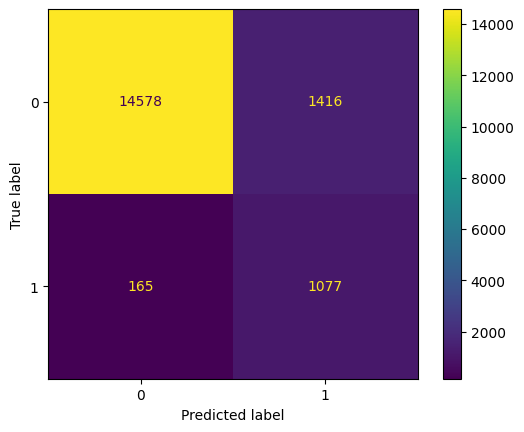

In [10]:
from icarlearn.ensemble.splitvotingens import SplitVotingEnsembleLGBM
from icarlearn.validation.crossvalidate import skfold_cv
from imblearn.metrics import specificity_score
from sklearn.metrics import *
myscorer = { 'ROC-AUC':      (roc_auc_score, {'multi_class':'ovr', 'average':'macro'}),
             'Accuracy'  :   (accuracy_score , {}),
             'BA'  :         (balanced_accuracy_score , {}),
             'Specificity' : (specificity_score, {'pos_label': 1}),
             'Sensitivity' : (recall_score   , {'pos_label': 1}),
             'MCC' :         (matthews_corrcoef, {}), 
            }
clf = SplitVotingEnsembleLGBM(**study.best_params)
df_scores, scores, predictions = skfold_cv(df_X, df_y, clf, n_splits=5, seed=0, scorer=myscorer, show_progress=True, verbose=True)
df_scores

In [6]:
#df = pd.read_csv(f'velgbm_{tissue}_hypersearch_mcc_ba_2.csv').sort_values(['values_1', 'values_0'], ascending=[False, False]).rename(columns={'values_0': 'BA', 'values_1': 'MCC'})
df = pd.read_csv(f'velgbm_Kidney_hypersearch_ba_cv.csv').sort_values('value', ascending=False).rename(columns={'value': 'BA'})
df.columns = df.columns.str.replace(r'params_', '')
selcolumns = ['boosting_type',	'learning_rate',	'n_estimators',	'n_voters', 'BA']
stds = df.std(numeric_only=True)
#df['BA+MCC'] = df.apply(lambda x: x.BA * stds.loc['BA'] + x.MCC * stds.loc['MCC'], axis=1)
#df['BA+MCC'] = df.apply(lambda x: x.BA  + x.MCC , axis=1)
print(df[selcolumns].sort_values('BA', ascending=False).to_latex())

\begin{tabular}{llrrrr}
\toprule
 & boosting_type & learning_rate & n_estimators & n_voters & BA \\
\midrule
44 & gbdt & 0.098461 & 200 & 8 & 0.892022 \\
33 & gbdt & 0.081512 & 200 & 8 & 0.890714 \\
43 & gbdt & 0.049017 & 200 & 8 & 0.888816 \\
34 & gbdt & 0.079823 & 200 & 7 & 0.887190 \\
23 & gbdt & 0.065070 & 140 & 13 & 0.886479 \\
48 & gbdt & 0.045185 & 180 & 9 & 0.886413 \\
35 & gbdt & 0.076854 & 200 & 7 & 0.886389 \\
21 & gbdt & 0.050629 & 160 & 9 & 0.886107 \\
49 & gbdt & 0.057144 & 200 & 8 & 0.886095 \\
37 & gbdt & 0.077908 & 200 & 7 & 0.886046 \\
32 & gbdt & 0.034572 & 180 & 11 & 0.885119 \\
22 & gbdt & 0.039571 & 180 & 12 & 0.884895 \\
41 & gbdt & 0.051064 & 200 & 7 & 0.884837 \\
29 & gbdt & 0.030759 & 180 & 10 & 0.884531 \\
6 & gbdt & 0.065527 & 100 & 12 & 0.884275 \\
0 & gbdt & 0.031088 & 180 & 11 & 0.884031 \\
31 & gbdt & 0.031174 & 180 & 10 & 0.883759 \\
15 & gbdt & 0.041630 & 160 & 9 & 0.883406 \\
24 & gbdt & 0.040524 & 140 & 15 & 0.882707 \\
20 & gbdt & 0.099690 & 60 & 10

# Load exisiting study from DB

In [19]:
import optuna
study = optuna.load_study(study_name='velgbm_Kidney', storage="sqlite:///../../results/veLGBM_Kidney_ba_cv.db")

RuntimeError: The runtime optuna version 3.6.1 is no longer compatible with the table schema (set up by optuna 3.1.1). Please execute `$ optuna storage upgrade --storage $STORAGE_URL` for upgrading the storage.

In [24]:
import pandas as pd
print(pd.read_csv("velgbm_Kidney_hypersearch_ba_cv.csv").replace({'':'','':'','':'','':''})sort_values('value', ascending=False).to_latex())

\begin{tabular}{lrrrllllrrrl}
\toprule
 & Unnamed: 0 & number & value & datetime_start & datetime_complete & duration & params_boosting_type & params_learning_rate & params_n_estimators & params_n_voters & state \\
\midrule
37 & 37 & 37 & 0.893151 & 2024-06-05 11:48:54.638670 & 2024-06-05 11:50:51.129284 & 0 days 00:01:56.490614 & gbdt & 0.094505 & 200 & 13 & COMPLETE \\
15 & 15 & 15 & 0.891459 & 2024-06-05 11:16:36.759285 & 2024-06-05 11:17:48.725832 & 0 days 00:01:11.966547 & gbdt & 0.098300 & 140 & 10 & COMPLETE \\
44 & 44 & 44 & 0.890954 & 2024-06-05 12:01:09.467990 & 2024-06-05 12:03:01.279431 & 0 days 00:01:51.811441 & gbdt & 0.076452 & 200 & 12 & COMPLETE \\
43 & 43 & 43 & 0.890826 & 2024-06-05 11:59:18.529245 & 2024-06-05 12:01:09.439684 & 0 days 00:01:50.910439 & gbdt & 0.075168 & 200 & 12 & COMPLETE \\
41 & 41 & 41 & 0.890602 & 2024-06-05 11:55:19.637376 & 2024-06-05 11:57:14.427060 & 0 days 00:01:54.789684 & gbdt & 0.078591 & 200 & 13 & COMPLETE \\
33 & 33 & 33 & 0.890241 & 